(tut_vsop2013)=

Introduction to the VSOP2013 planetary theory
==========

```{versionadded} 0.15.0

```

heyoka.py provides an implementation of the [VSOP2013](https://en.wikipedia.org/wiki/VSOP_%28planets%29) planetary theory. VSOP2013 consists of a set of (large) analytical formulae expressing the heliocentric orbital elements of the 8 planets of the Solar System (plus the dwarf planet Pluto) as a function of time. Because the VSOP2013 theory is expressed as a set of analytical, differentiable formulae, it can be implemented in heyoka.py's expression system and it can thus be used in the formulation of differential equations.

API overview
-------

heyoka.py provides three functions to generate the analytical formulae for the VSOP2013 theory. These functions are available in the {ref}`model <api_model>` submodule.

The first one, {py:func}`~heyoka.model.vsop2013_elliptic()`, returns the time-dependent formulae for the heliocentric elliptic orbital elements for a given planet. The 6 elliptic orbital elements are, in order:

* the semi-major axis $a$ (in astronomical units),
* the [mean longitude](https://en.wikipedia.org/wiki/Mean_longitude) $\lambda$ (in radians),
* $k=e\cos\varpi$ and $h=e\sin\varpi$, where $e$ is the eccentricity and $\varpi=\Omega+\omega$ is the [longitude of the perihelion](https://en.wikipedia.org/wiki/Longitude_of_the_periapsis),
* $q=\sin\frac{i}{2}\cos\Omega$ and $p=\sin\frac{i}{2}\sin\Omega$, where $i$ is the inclination and $\Omega$ is the longitude of the ascending node.

This function requires as input the planet index (from 1 to 9) and the orbital element index (from 1 to 6). The orbital elements are referred to the inertial frame defined by the dynamical equinox and ecliptic J2000. Note that the VSOP2013 solution for the Earth (planet index 3) actually refers to the Earth-Moon barycentre.

The second function, {py:func}`~heyoka.model.vsop2013_cartesian()`, returns the heliocentric Cartesian state vector $\left( x, y, z, v_x, v_y, v_z \right)$ for a given planet. The Cartesian state is computed via a direct conversion of the orbital elements returned by {py:func}`~heyoka.model.vsop2013_elliptic()`, and thus it also refers to the inertial frame defined by the dynamical equinox and ecliptic J2000. Positions are given in AU, velocities in AU/day.

The third function, {py:func}`~heyoka.model.vsop2013_cartesian_icrf()`, returns the heliocentric Cartesian state vector for a given planet in the [ICRS](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_Frame). The ICRS state vector is computed by applying a rotation to the output of {py:func}`~heyoka.model.vsop2013_cartesian()`.

Precision and truncation threshold
--------

The VSOP2013 solution is formulated as large Fourier/Poisson series whose numerical coefficients decay exponentially. When using the full VSOP2013 solution, the precision with respect to high-accuracy numerical integrations is roughly sub-meter for the inner planets (except Mars) and kilometers for the outer planets (except Pluto). By dropping the smaller terms from the series, the precision of the theory degrades but computational efficiency greatly increases. See the [VSOP2013 readme](https://ftp.imcce.fr/pub/ephem/planets/vsop2013/solution/README.pdf) for more details and estimates of the precision at various truncation levels.

By default, all ``vsop2013_*()`` functions filter out from the solution terms whose numerical coefficients have a magnitude smaller than $10^{-9}$. This corresponds to an accuracy of the order of a few kilometers on the Cartesian positions of the terrestrial planets. The truncation threshold can be changed via the ``thresh`` keyword argument:

In [1]:
import heyoka as hy

for thr in [1e-7, 1e-9, 1e-11]:
    print(
        "Size of Mars' semi-major axis solution @ {}: {}".format(
            thr, len(hy.model.vsop2013_elliptic(4, 1, thresh=thr))
        )
    )

Size of Mars' semi-major axis solution @ 1e-07: 4936
Size of Mars' semi-major axis solution @ 1e-09: 48708
Size of Mars' semi-major axis solution @ 1e-11: 469536


Time coordinate
-----

The precision of the VSOP2013 solution is highest betwen $1890\,\mathrm{CE}$ and $2000\,\mathrm{CE}$, and it slowly degrades outside this time range. See the [VSOP2013 readme](https://ftp.imcce.fr/pub/ephem/planets/vsop2013/solution/README.pdf) for estimates of the precision degradation up to a few thousand years in the past/future.

VSOP2013 uses [barycentric dynamical time (TDB)](https://en.wikipedia.org/wiki/Barycentric_Dynamical_Time), expressed in thousands of Julian years from J2000 (JD2451545.0). Note than one Julian year = 365.25 days.

By default, all ``vsop2013_*()`` functions use {py:attr}`heyoka.time` to represent the time variable in the VSOP2013 formulae. This means that, by default, when the VSOP2013 solution is used in an ODE system, time is assumed to be measured in thousands of Julian years of TDB and $t = 0$ corresponds to the Julian date $2451545.0$:

In [2]:
print(
    "Mars' semi-major axis solution, threshold = 6e-5, default time expression:\n{}\n".format(
        hy.model.vsop2013_elliptic(4, 1, thresh=6e-5)
    )
)

Mars' semi-major axis solution, threshold = 6e-5, default time expression:
(1.5236793402339999 + ((2.1017753733317330e-07 * sin(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * t))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * t)))))) + (6.6017042784613703e-05 * cos(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * t))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * t))))))))



It is possible to change the expression used to represent the time variable in the VSOP2013 solution via the ``time_expr`` keyword argument. This allows to rescale and change the origin of time in the VSOP2013 formulae.

For instance, if we want time to be measured in Julian days (rather than millenia) since J2000, we can write:

In [3]:
print(
    "Mars' semi-major axis solution, threshold = 6e-5, time in days since J2000:\n{}\n".format(
        hy.model.vsop2013_elliptic(4, 1, time_expr=hy.time / 365250.0, thresh=6e-5)
    )
)

Mars' semi-major axis solution, threshold = 6e-5, time in days since J2000:
(1.5236793402339999 + ((2.1017753733317330e-07 * sin(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * (2.7378507871321011e-06 * t)))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * (2.7378507871321011e-06 * t))))))) + (6.6017042784613703e-05 * cos(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * (2.7378507871321011e-06 * t)))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * (2.7378507871321011e-06 * t)))))))))



In a similar fashion, we can change the origin of the time coordinate by adding/subtracting an offset to {py:attr}`heyoka.time`. For instance, if we want to be able to use directly the Julian date as time variable (rather than the number of Julian days since J2000), we can write:

In [4]:
print(
    "Mars' semi-major axis solution, threshold = 6e-5, time in JD:\n{}\n".format(
        hy.model.vsop2013_elliptic(
            4, 1, time_expr=(hy.time - 2451545.0) / 365250.0, thresh=6e-5
        )
    )
)

Mars' semi-major axis solution, threshold = 6e-5, time in JD:
(1.5236793402339999 + ((2.1017753733317330e-07 * sin(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * (2.7378507871321011e-06 * (t - 2451545.0000000000))))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * (2.7378507871321011e-06 * (t - 2451545.0000000000)))))))) + (6.6017042784613703e-05 * cos(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * (2.7378507871321011e-06 * (t - 2451545.0000000000))))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * (2.7378507871321011e-06 * (t - 2451545.0000000000))))))))))



Note that the time expression passed to the ``vsop2013_*()`` functions does not need to be based on {py:attr}`heyoka.time` - in fact *any* expression can be used as a time coordinate in the VSOP2013 formulae:

In [5]:
print(
    "Mars' semi-major axis solution, threshold = 6e-5, time represented as the 'x' variable:\n{}\n".format(
        hy.model.vsop2013_elliptic(4, 1, time_expr=hy.expression("x"), thresh=6e-5)
    )
)

Mars' semi-major axis solution, threshold = 6e-5, time represented as the 'x' variable:
(1.5236793402339999 + ((2.1017753733317330e-07 * sin(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * x))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * x)))))) + (6.6017042784613703e-05 * cos(((2.0000000000000000 * (6.2035000141410004 + (3340.6124341454570 * x))) - (2.0000000000000000 * (0.59954610703500000 + (529.69096156232501 * x))))))))



Checking the implementation
-----

In order to check the correctness of heyoka.py's implementation of the VSOP2013 theory, we are going to use the [NASA HORIZONS service](https://ssd.jpl.nasa.gov/?horizons) via the [Astroquery](https://astroquery.readthedocs.io/en/latest/) package. Our objective is to compare the planetary positions computed by VSOP2013 at different threshold levels with those computed by HORIZONS. On the heyoka.py side, we will be using [compiled functions](<./compiled_functions.ipynb>) to evaluate the VSOP2013 series.

In this example, we will be using Venus as a target body. Because the ecliptical coordinate system used by VSOP2013 does not match exactly any of the coordinate systems available in HORIZONS, we will be using the {py:func}`~heyoka.model.vsop2013_cartesian_icrf()` function instead, which outputs heliocentric Cartesian coordinates in the standard [ICRS](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_Frame) (which is available in HORIZONS). Let's take a look at the code and at the results:

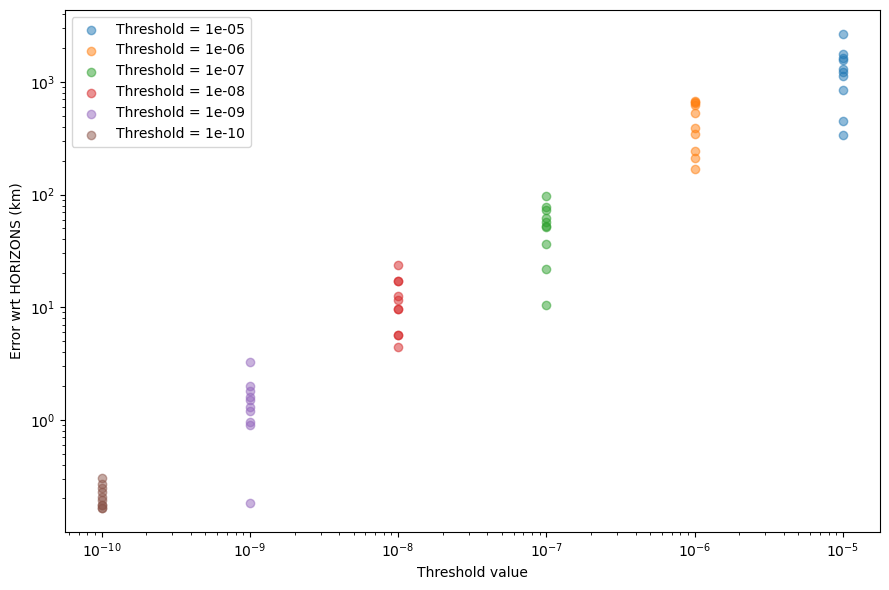

In [6]:
%matplotlib inline
from matplotlib.pylab import plt
import numpy as np
from astroquery.jplhorizons import Horizons

# Setup the plot.
fig = plt.figure(figsize=(9, 6))
plt.xscale("log")
plt.yscale("log")

# Create a heyoka variable for representing time.
tm = hy.make_vars("tm")

# Threshold levels at which we will be computing
# the VSOP2013 solution.
thr_values = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]

# We will perform 10 evaluations of the
# position of Venus in the 10 years following
# J2000.
dates = np.linspace(2451545.0, 2451545.0 + 365 * 10, 10)

for thr in thr_values:
    # Build the VSOP2013 formulae for the heliocentric Cartesian
    # position of Venus (planet index 2) in the ICRF. Replace the
    # default time variable and set a custom threshold level.
    venus_x, venus_y, venus_z = hy.model.vsop2013_cartesian_icrf(
        2,
        # NOTE: measure time
        # using the Julian date.
        time_expr=(tm - 2451545.0) / 365250.0,
        thresh=thr,
    )[:3]

    # Compile the function for the evaluation of venus_x/y/z.
    venus_cf = hy.cfunc([venus_x, venus_y, venus_z], [tm], compact_mode=True)

    # Run the evaluation.
    vsop_states = venus_cf(dates.reshape((1, -1)))

    # HORIZONS query:
    # - 299 is the ID of Venus,
    # - 500@10 is the observer's location,
    #   the centre of the Sun.
    q = Horizons("299", location="500@10", epochs=dates)
    # Convert the HORIZONS query to the ICRF
    # and extract the cartesian position vector.
    tab = q.vectors(refplane="earth")
    hor_x = tab["x"].quantity[:].value
    hor_y = tab["y"].quantity[:].value
    hor_z = tab["z"].quantity[:].value

    hor_states = np.array([hor_x, hor_y, hor_z])

    # Plot the difference (in km) between the positions computed
    # by VSOP2013 and HORIZONS.
    AU = 149597870.7
    plt.scatter(
        [thr] * len(dates),
        np.linalg.norm(vsop_states - hor_states, axis=0) * AU,
        alpha=0.5,
        label="Threshold = {}".format(thr),
    )

# Finish setting up the plot.
plt.legend()
plt.xlabel("Threshold value")
plt.ylabel("Error wrt HORIZONS (km)")
plt.tight_layout();

We can see how VSOP2013 matches up well with respect to HORIZONS, and how lower truncation levels indeed increase the precision of the VSOP2013 solution (up to an error of hundreds of meters for a threshold of $10^{-10}$).

Limitations and caveats
-----

Like most analytical theories, VSOP2013 excels at high thresholds (i.e., low precisions), where it provides compact formulae that can be evaluated quickly. As the precision increases, the solution becomes exponentially longer and more computationally expensive to evaluate and thus less appealing from the point of view of astrodynamical applications.